# Problem 1: Clustering

## A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage.

 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [49]:
df=pd.read_csv('bank_marketing_part1_Data.csv')
df.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                       0.8752            6.675   
1     15.99             14.89                       0.9064            5.363   
2     18.95             16.42                       0.8829            6.248   
3     10.83             12.96                       0.8099            5.278   
4     17.99             15.86                       0.8992            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  
0         3.763            3.252                         6.550  
1         3.582            3.336                         5.144  
2         3.755            3.368                         6.148  
3         2.641            5.182                         5.185  
4         3.694            2.068                         5.837

In [50]:
df.describe()

spending  advance_payments  probability_of_full_payment  \
count  210.000000        210.000000                   210.000000   
mean    14.847524         14.559286                     0.870999   
std      2.909699          1.305959                     0.023629   
min     10.590000         12.410000                     0.808100   
25%     12.270000         13.450000                     0.856900   
50%     14.355000         14.320000                     0.873450   
75%     17.305000         15.715000                     0.887775   
max     21.180000         17.250000                     0.918300   

       current_balance  credit_limit  min_payment_amt  \
count       210.000000    210.000000       210.000000   
mean          5.628533      3.258605         3.700201   
std           0.443063      0.377714         1.503557   
min           4.899000      2.630000         0.765100   
25%           5.262250      2.944000         2.561500   
50%           5.523500      3.237000         3.599000   
75%           5.979750      3.561750         4.768750   
max           6.675000      4.033000         8.456000   

       max_spent_in_single_shopping  
count                    210.000000  
mean                       5.408071  
std                        0.491480  
min                        4.519000  
25%                        5.045000  
50%                        5.223000  
75%                        5.877000  
max                        6.550000

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


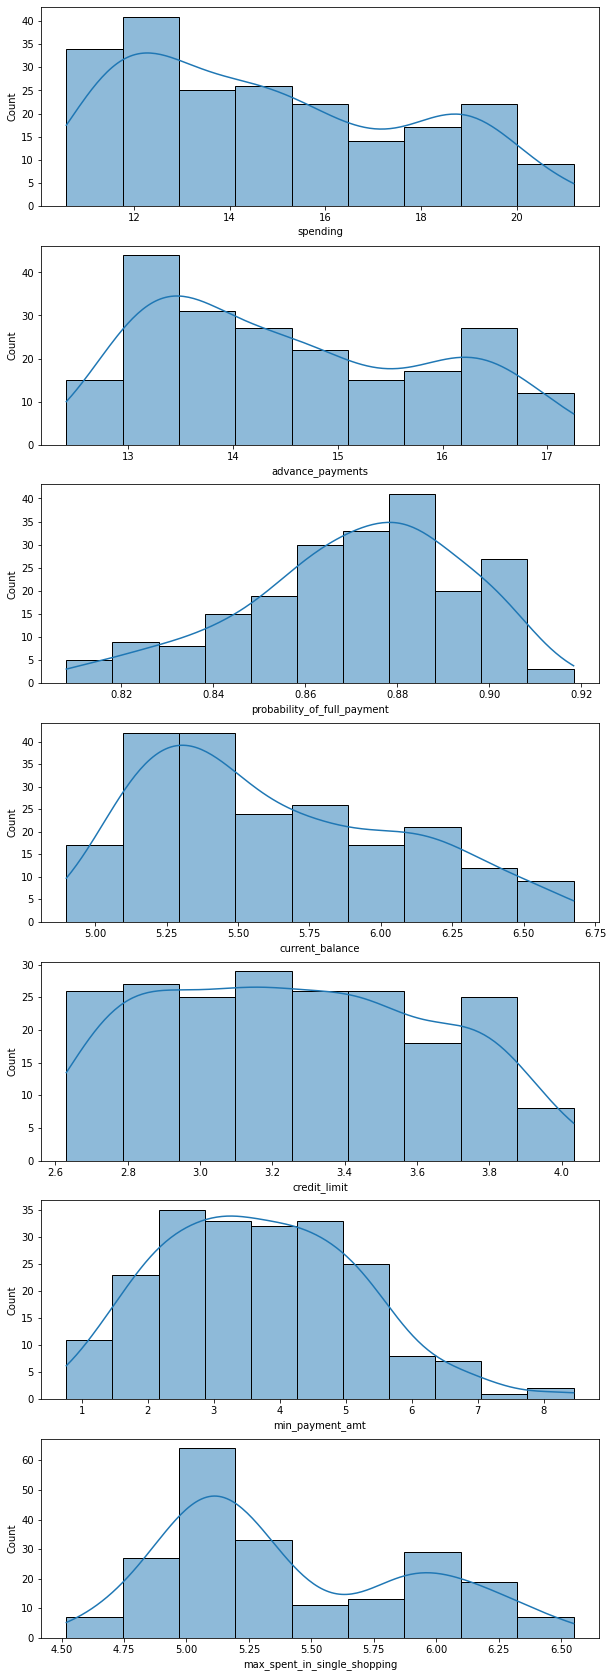

In [52]:

f,ax=plt.subplots(7,figsize=(10,30))
for i,j in enumerate(df.columns):
    sns.histplot(df[j],ax=ax[i],kde=True)
    

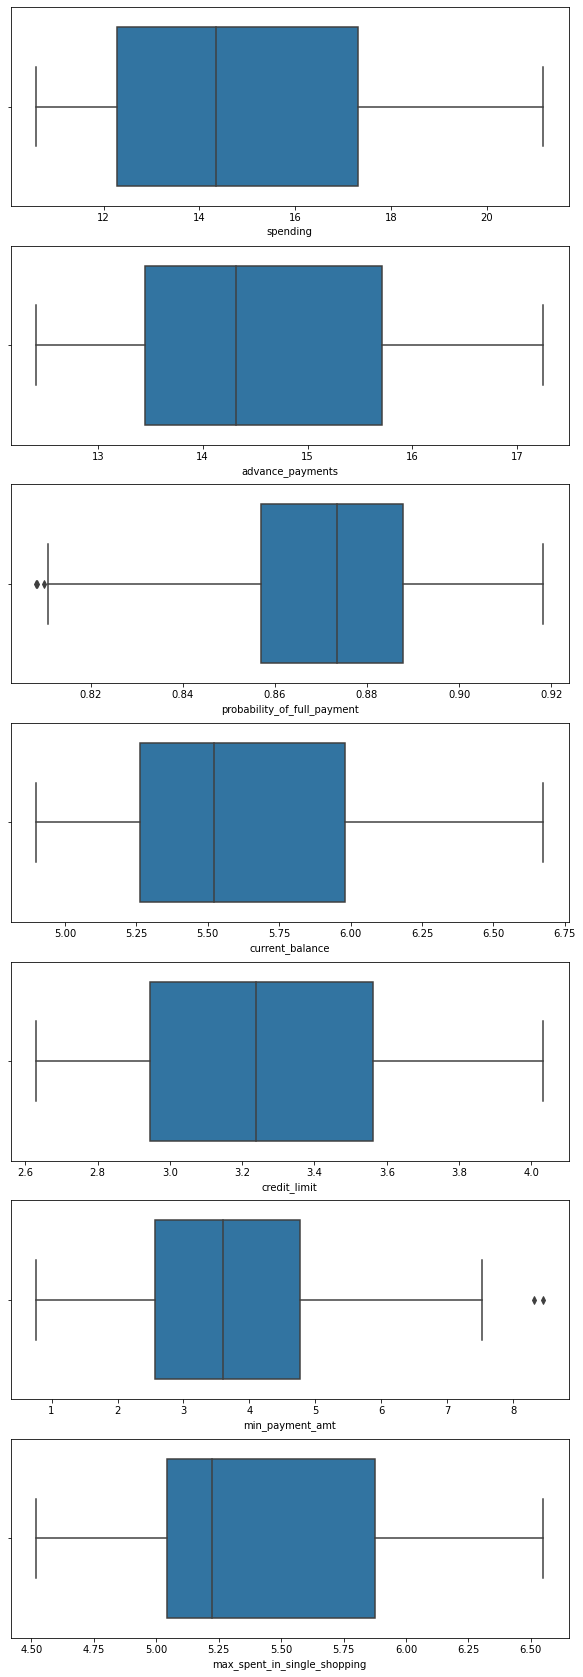

In [53]:

f,ax=plt.subplots(7,figsize=(10,30))
for i,j in enumerate(df.columns):
    sns.boxplot(x=df[j],ax=ax[i])
    

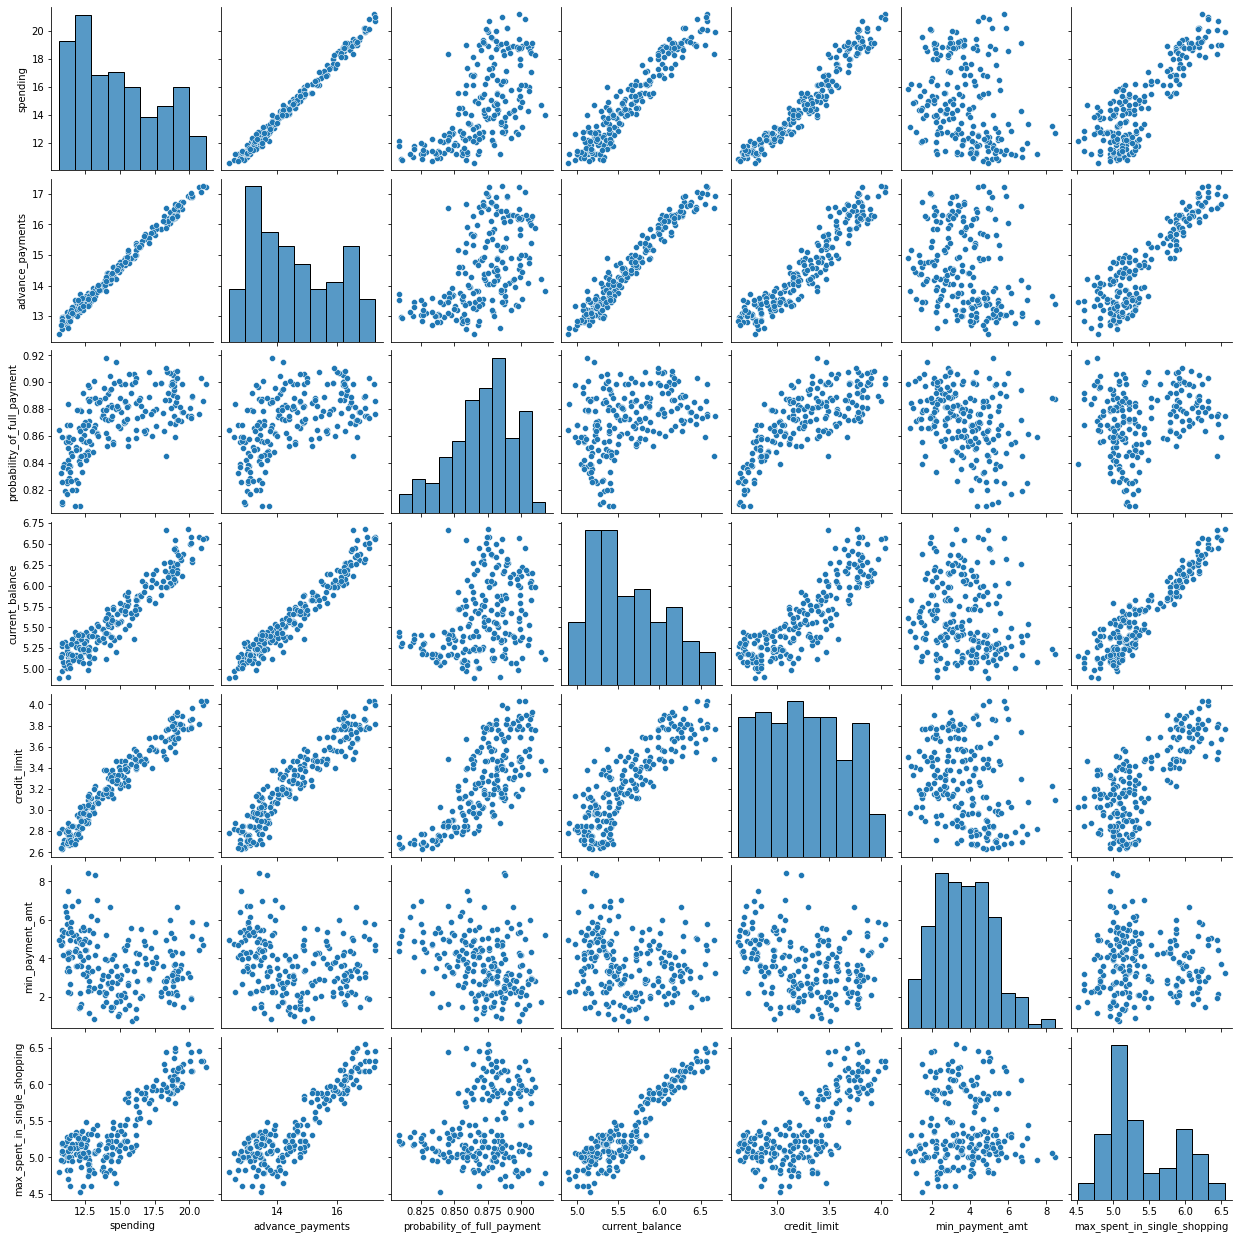

In [54]:
sns.pairplot(data=df)

In [55]:
df.skew()

spending                        0.399889
advance_payments                0.386573
probability_of_full_payment    -0.537954
current_balance                 0.525482
credit_limit                    0.134378
min_payment_amt                 0.401667
max_spent_in_single_shopping    0.561897
dtype: float64

In [56]:
def range_finder(column):
    q1,q3=column.quantile([0.25,0.75])
    iqr=q3-q1
    
    upper_limit=q3+(1.5*iqr)
    lower_limit=q1-(1.5*iqr)
    
    return upper_limit,lower_limit

In [57]:
for i in ['probability_of_full_payment','min_payment_amt']:
    UL,LL=range_finder(df[i])
    q5,q95=df[i].quantile([0.05,0.95])
    df[i]=np.where(df[i] > UL,q95,df[i])
    df[i]=np.where(df[i]< LL,q5,df[i])

In [58]:
np.percentile(df['spending'],25)

12.27

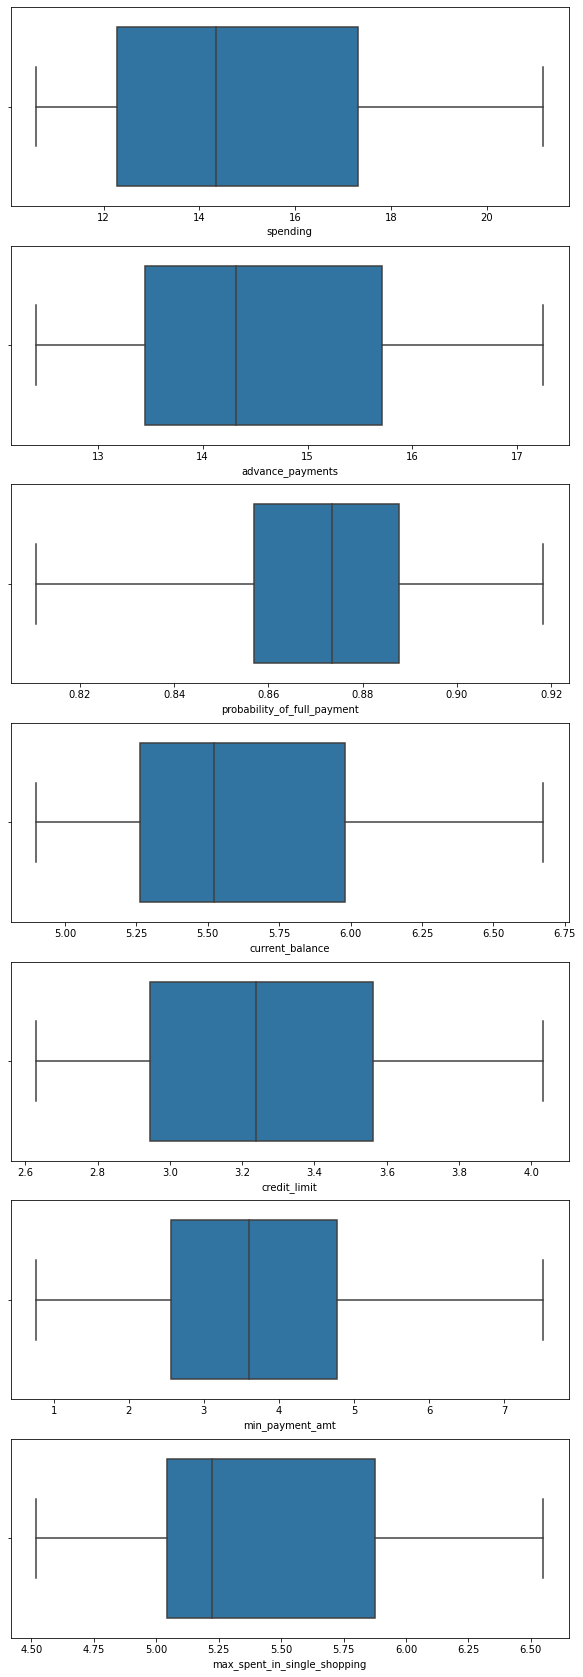

In [59]:

f,ax=plt.subplots(7,figsize=(10,30))
for i,j in enumerate(df.columns):
    sns.boxplot(x=df[j],ax=ax[i])
    

In [60]:
df.duplicated().sum()

0

In [61]:
corr=df.corr(method='pearson')

<AxesSubplot:>

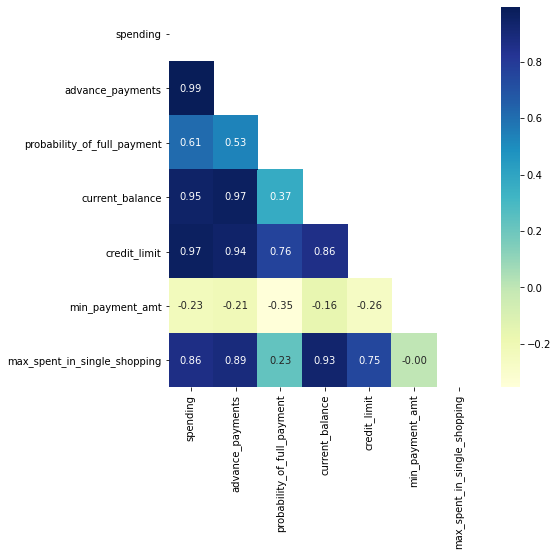

In [62]:
mask=np.triu(np.ones_like(corr))
plt.figure(figsize=(7,7))
sns.heatmap(corr,annot=True,fmt='.2f',mask=mask,cmap='YlGnBu')

In [63]:
from scipy.stats import zscore

In [64]:
scaled_data=df.apply(zscore)
scaled_data.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0  1.754355          1.811968                     0.171955         2.367533   
1  0.393582          0.253840                     1.528129        -0.600744   
2  1.413300          1.428192                     0.506652         1.401485   
3 -1.384034         -1.227533                    -1.970322        -0.793049   
4  1.082581          0.998364                     1.215165         0.591544   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  
0      1.338579        -0.294861                      2.328998  
1      0.858236        -0.236880                     -0.538582  
2      1.317348        -0.214791                      1.509107  
3     -1.639017         1.037338                     -0.454961  
4      1.155464        -1.112128                      0.874813

In [65]:
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster

In [66]:
linkage_method=linkage(scaled_data,method='ward',metric='euclidean')

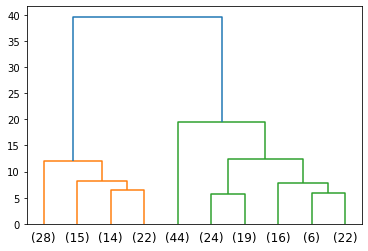

In [67]:
dend=dendrogram(linkage_method,truncate_mode='lastp',p=10,labels=scaled_data.index)

In [68]:
clusters=fcluster(linkage_method,3,criterion='maxclust')
df['clusters']=clusters
df.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                     0.875200            6.675   
1     15.99             14.89                     0.906400            5.363   
2     18.95             16.42                     0.882900            6.248   
3     10.83             12.96                     0.825915            5.278   
4     17.99             15.86                     0.899200            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  clusters  
0         3.763            3.252                         6.550         1  
1         3.582            3.336                         5.144         2  
2         3.755            3.368                         6.148         1  
3         2.641            5.182                         5.185         3  
4         3.694            2.068                         5.837         1

<AxesSubplot:xlabel='clusters', ylabel='spending'>

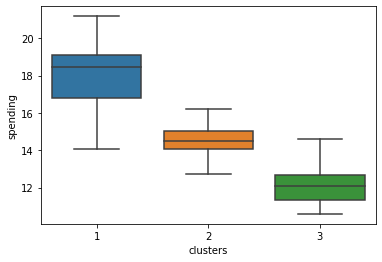

In [69]:
sns.boxplot(data=df,x='clusters',y='spending')

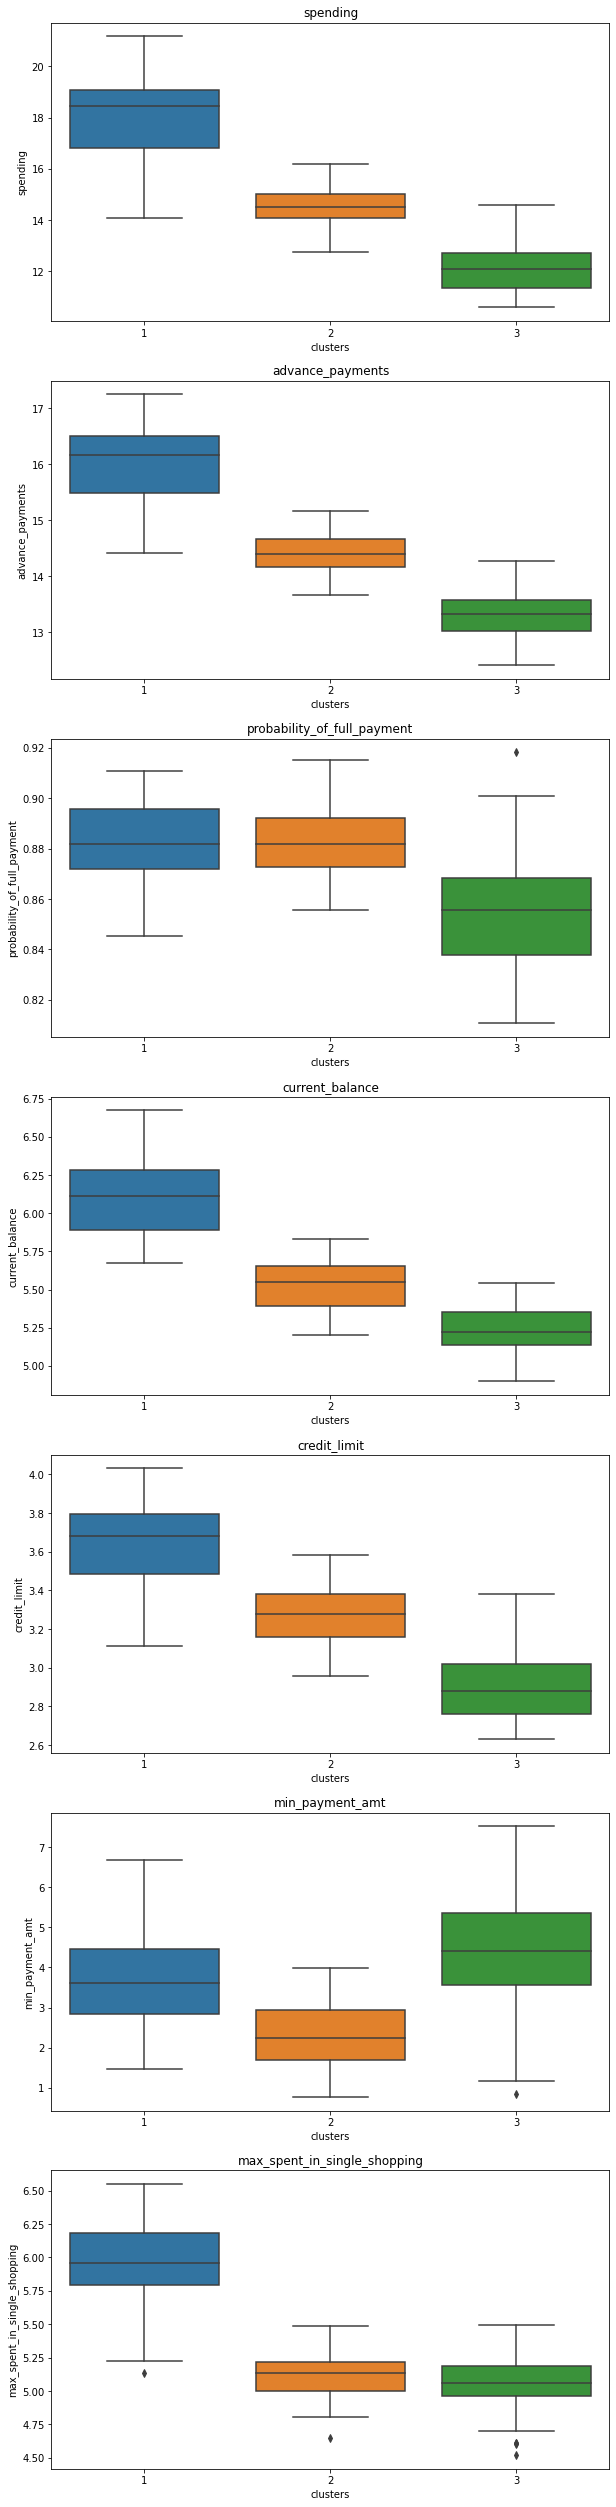

In [70]:
f,ax=plt.subplots(7,figsize=(10,45))
for i,j in enumerate([x for x in df.columns if x not in ['clusters']]):
    sns.boxplot(y=j,ax=ax[i],x='clusters',data=df)
    ax[i].set_title(j)
    


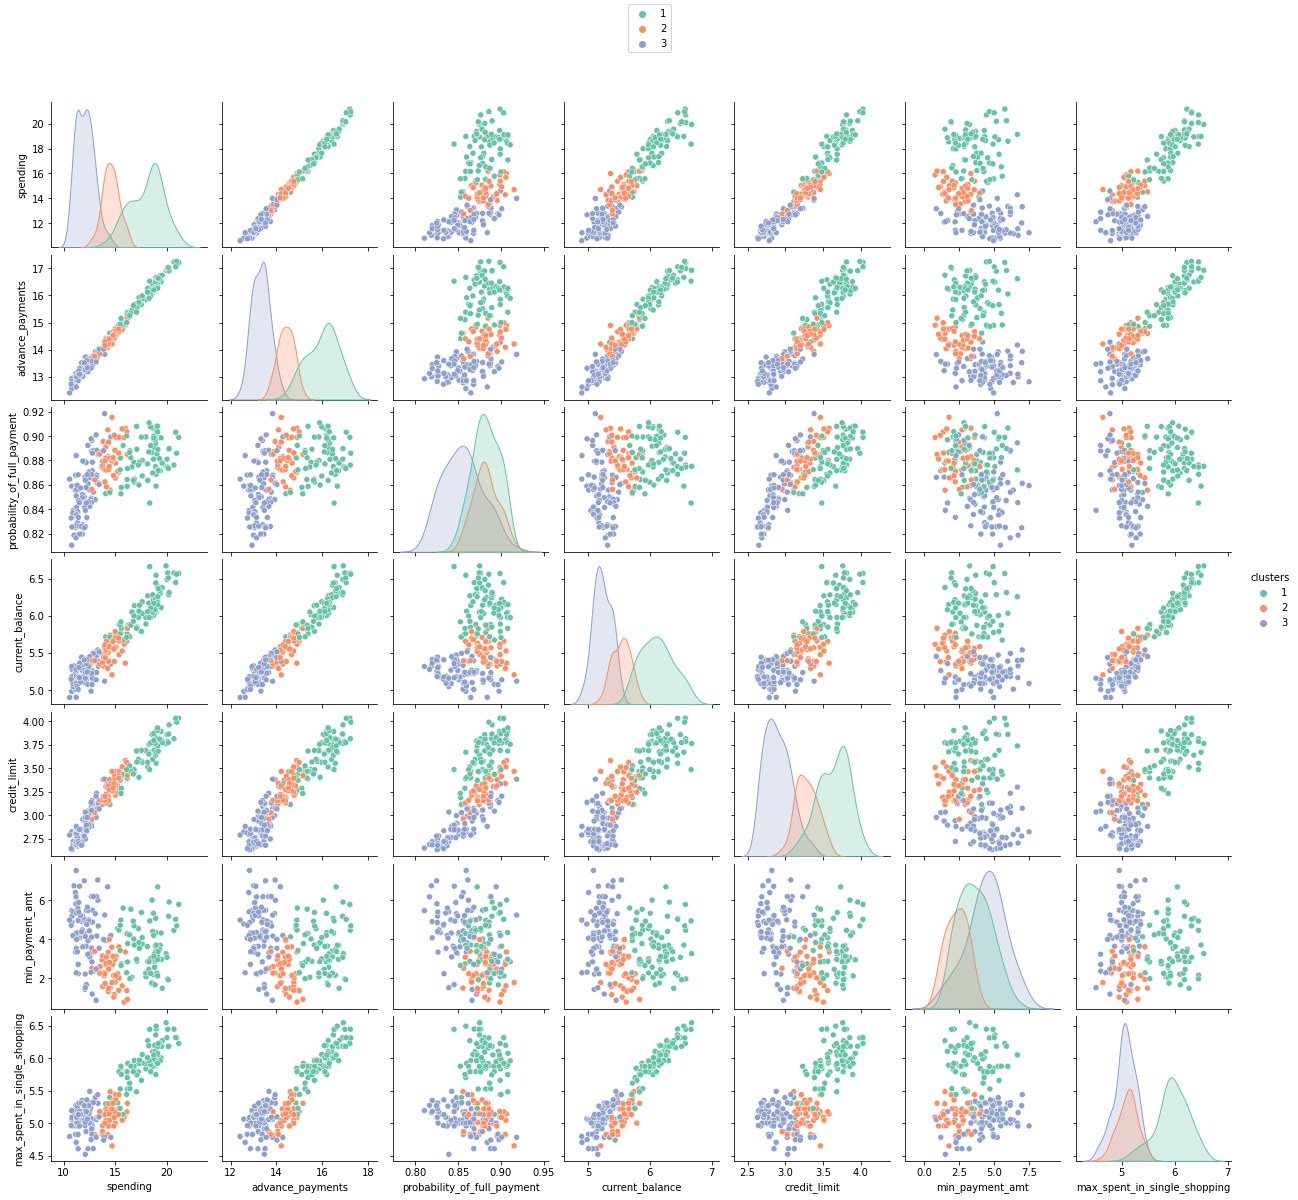

In [71]:
g=sns.pairplot(data=df,hue='clusters',palette='Set2')
handles=g._legend_data.values()
labels=g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

In [72]:
clus_prof=df.groupby('clusters').mean()
clus_prof['frequency']=df['clusters'].value_counts().sort_index()
clus_prof

spending  advance_payments  probability_of_full_payment  \
clusters                                                             
1         18.039367         16.011266                     0.882377   
2         14.582955         14.407045                     0.882357   
3         12.082989         13.317816                     0.855514   

          current_balance  credit_limit  min_payment_amt  \
clusters                                                   
1                6.117468      3.641975         3.627253   
2                5.535318      3.283818         2.316775   
3                5.231701      2.897736         4.415353   

          max_spent_in_single_shopping  frequency  
clusters                                           
1                             5.957266         79  
2                             5.109841         44  
3                             5.060207         87

In [73]:
from sklearn.cluster import KMeans

In [74]:
wss=[]
for i in range(2,11):
    km=KMeans(n_clusters=i)
    km.fit(scaled_data)
    wss.append(km.inertia_)
print(pd.Series(wss,index=range(2,11)))

2     659.130812
3     429.413963
4     369.439970
5     322.197003
6     290.610818
7     262.042834
8     239.861003
9     223.862179
10    205.685123
dtype: float64


Text(0.5, 1.0, 'Elbow plot')

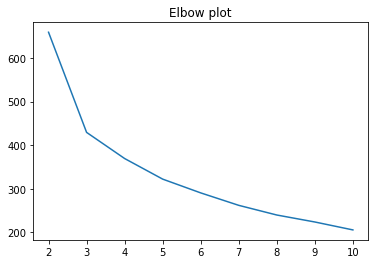

In [75]:
plt.plot(range(2,11),wss)
plt.title('Elbow plot')

In [76]:
from sklearn.metrics import silhouette_score

In [77]:
sil_score=[]
for i in range(2,11):
    km=KMeans(n_clusters=i)
    km.fit(scaled_data)
    labels=km.labels_
    sil_score.append(silhouette_score(scaled_data,labels))
    

Text(0.5, 1.0, 'Silhouette score')

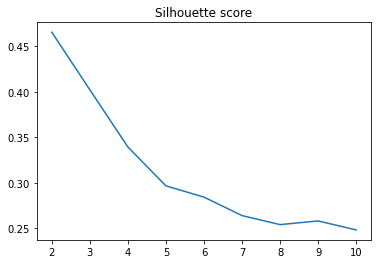

In [78]:
plt.plot(range(2,11),sil_score)
plt.title('Silhouette score')

In [79]:
pd.Series(sil_score,index=range(2,11))

2     0.465329
3     0.402193
4     0.339337
5     0.296654
6     0.284312
7     0.264050
8     0.254099
9     0.258166
10    0.248296
dtype: float64

In [80]:
km=KMeans(n_clusters=5)
km.fit(scaled_data)
df['Kmeans_cluster']=km.labels_

In [81]:
df.head()

spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                     0.875200            6.675   
1     15.99             14.89                     0.906400            5.363   
2     18.95             16.42                     0.882900            6.248   
3     10.83             12.96                     0.825915            5.278   
4     17.99             15.86                     0.899200            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  clusters  \
0         3.763            3.252                         6.550         1   
1         3.582            3.336                         5.144         2   
2         3.755            3.368                         6.148         1   
3         2.641            5.182                         5.185         3   
4         3.694            2.068                         5.837         1   

   Kmeans_cluster  
0               0  
1               2  
2               0  
3               1  
4               0

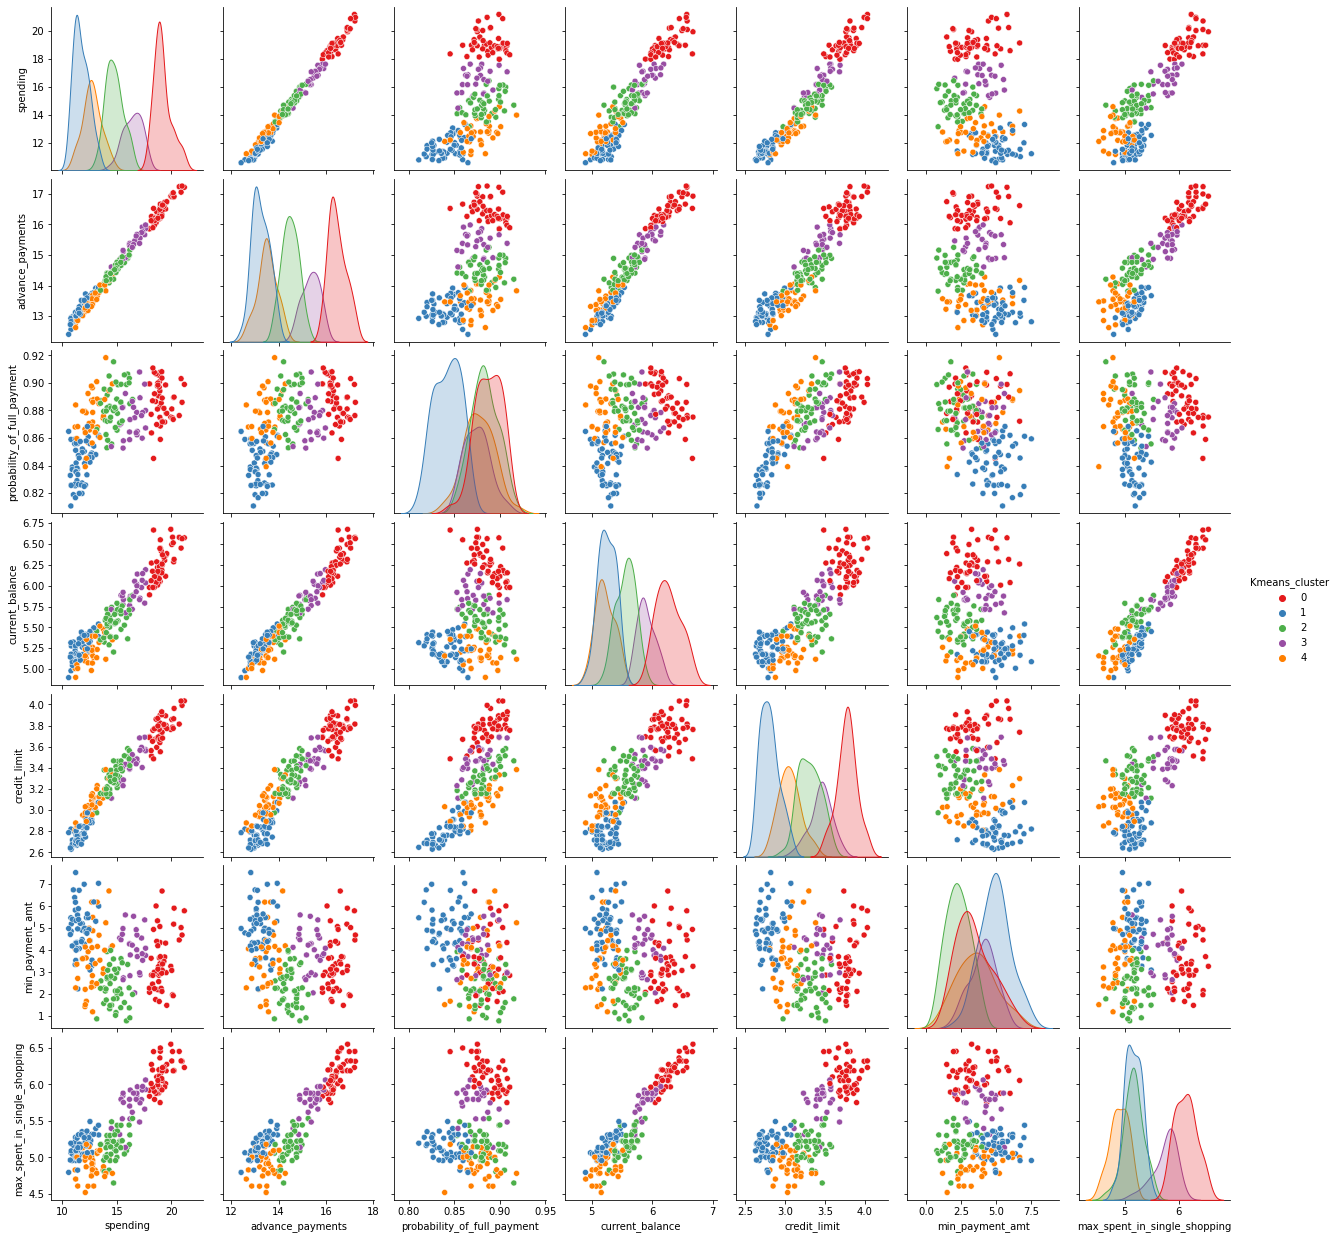

In [82]:
sns.pairplot(data=df.drop(columns='clusters'),hue='Kmeans_cluster',palette='Set1')

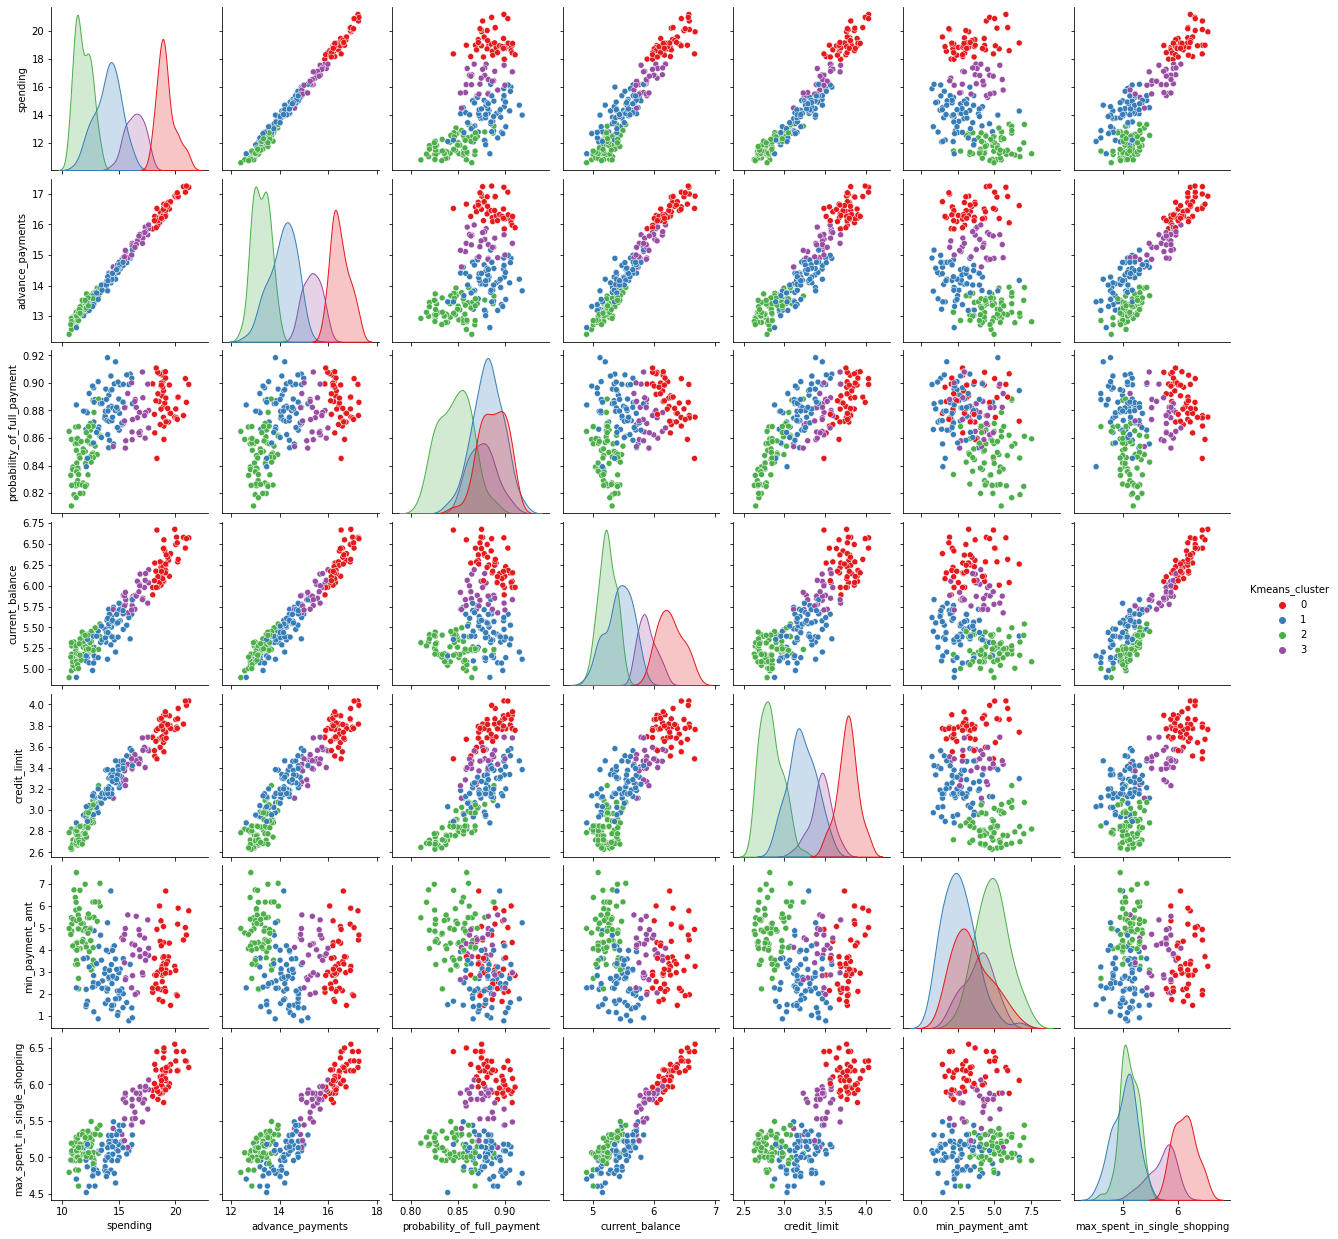

In [83]:
km=KMeans(n_clusters=4)
km.fit(scaled_data)
df['Kmeans_cluster']=km.labels_
sns.pairplot(data=df.drop(columns='clusters'),hue='Kmeans_cluster',palette='Set1')

In [84]:
df.drop(columns='clusters').groupby('Kmeans_cluster').mean()

spending  advance_payments  probability_of_full_payment  \
Kmeans_cluster                                                             
0               19.151042         16.469167                     0.887090   
1               14.013284         14.122836                     0.881506   
2               11.816462         13.242154                     0.846853   
3               16.392333         15.332000                     0.875820   

                current_balance  credit_limit  min_payment_amt  \
Kmeans_cluster                                                   
0                      6.268854      3.772937         3.460417   
1                      5.432612      3.217075         2.606675   
2                      5.237600      2.834354         4.851486   
3                      5.888600      3.447633         3.884433   

                max_spent_in_single_shopping  
Kmeans_cluster                                
0                                   6.127250  
1                                   5.036567  
2                                   5.121846  
3                                   5.707233

# Problem 2: CART-RF-ANN

1. Target: Claim Status (Claimed)
2. Code of tour firm (Agency_Code)
3. Type of tour insurance firms (Type)
4. Distribution channel of tour insurance agencies (Channel)
5. Name of the tour insurance products (Product)
6. Duration of the tour (Duration)
7. Destination of the tour (Destination)
8. Amount of sales of tour insurance policies (Sales)
9. The commission received for tour insurance firm (Commission)
10. Age of insured (Age)

In [85]:
data=pd.read_csv('insurance_part2_data.csv')

In [86]:
data.head()

Age Agency_Code           Type Claimed  Commision Channel  Duration  Sales  \
0   48         C2B       Airlines      No       0.70  Online         7   2.51   
1   36         EPX  Travel Agency      No       0.00  Online        34  20.00   
2   39         CWT  Travel Agency      No       5.94  Online         3   9.90   
3   36         EPX  Travel Agency      No       0.00  Online         4  26.00   
4   33         JZI       Airlines      No       6.30  Online        53  18.00   

        Product Name Destination  
0    Customised Plan        ASIA  
1    Customised Plan        ASIA  
2    Customised Plan    Americas  
3  Cancellation Plan        ASIA  
4        Bronze Plan        ASIA

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [88]:
data.describe()

Age    Commision     Duration        Sales
count  3000.000000  3000.000000  3000.000000  3000.000000
mean     38.091000    14.529203    70.001333    60.249913
std      10.463518    25.481455   134.053313    70.733954
min       8.000000     0.000000    -1.000000     0.000000
25%      32.000000     0.000000    11.000000    20.000000
50%      36.000000     4.630000    26.500000    33.000000
75%      42.000000    17.235000    63.000000    69.000000
max      84.000000   210.210000  4580.000000   539.000000

In [89]:
data.duplicated().sum()

139

In [90]:
data.drop_duplicates(keep='first',inplace=True)

In [91]:
data.duplicated().sum()

0

In [92]:
data.isna().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

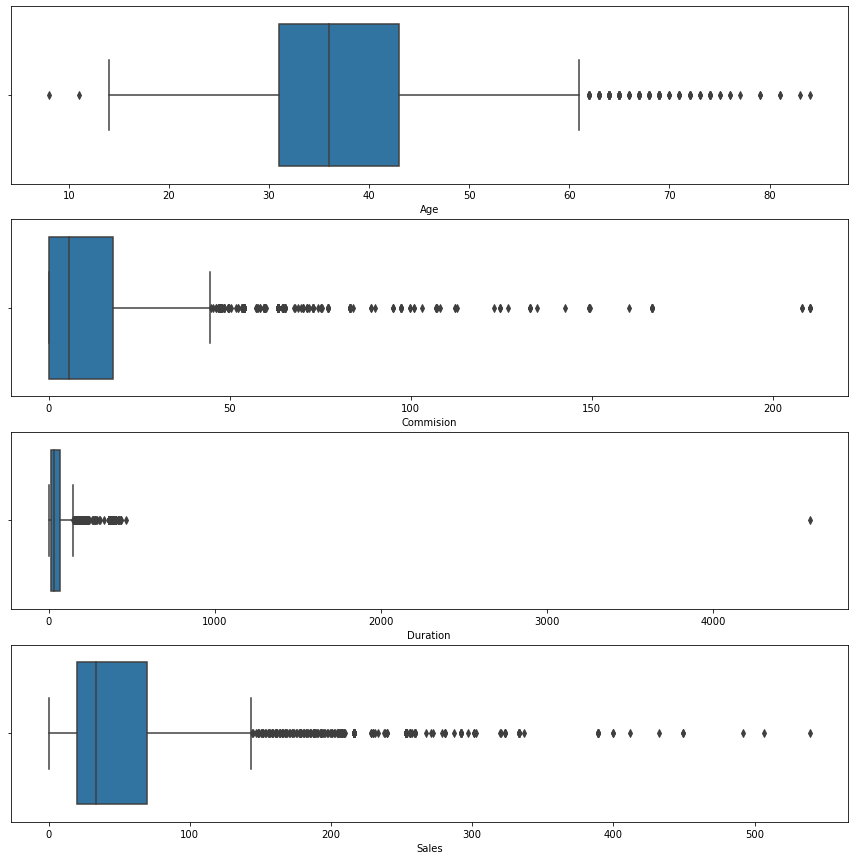

In [93]:
num_cols=data.dtypes[data.dtypes!='object'].index
f,ax=plt.subplots(4,figsize=(15,15))
for i,j in enumerate(num_cols):
    sns.boxplot(data=data,ax=ax[i],x=j)

In [94]:
outliers=0
for i in num_cols:
    UL,LL=range_finder(data[i])
    outliers+=data[data[i] >UL].shape[0] + data[data[i] < LL].shape[0]
print('Percentage of outliers',outliers/data.shape[0])

Percentage of outliers 0.41663753932191544


In [95]:
data[(data.Duration ==-1)]

Age Agency_Code      Type Claimed  Commision Channel  Duration  Sales  \
1508   25         JZI  Airlines      No        6.3  Online        -1   18.0   

     Product Name Destination  
1508  Bronze Plan        ASIA

In [96]:
data.Duration=data.Duration.replace(-1,1)

In [97]:
cat_cols=[x for x in data.columns if x not in num_cols]
for i in cat_cols:
    print(i,' ',data[i].unique())

Agency_Code   ['C2B' 'EPX' 'CWT' 'JZI']
Type   ['Airlines' 'Travel Agency']
Claimed   ['No' 'Yes']
Channel   ['Online' 'Offline']
Product Name   ['Customised Plan' 'Cancellation Plan' 'Bronze Plan' 'Silver Plan'
 'Gold Plan']
Destination   ['ASIA' 'Americas' 'EUROPE']


In [98]:
for i in num_cols:
    print(i,' ',data[i].unique())

Age   [48 36 39 33 45 61 37 43 52 31 23 29 28 27 44 46 25 60 30 40 32 26 38 42
 51 24 59 41 56 35 58 73 47 50 22 20 53 68 34 79 19 21 66 69 57 63 54 64
 71 49 62 84 17 55 76 72 65 67 75 70 18 77 14 81 74  8 16 83 15 11]
Commision   [7.0000e-01 0.0000e+00 5.9400e+00 6.3000e+00 1.5750e+01 3.5640e+01
 4.6960e+01 1.5880e+01 5.8800e+00 2.3760e+01 5.4000e+01 5.9400e+01
 1.8200e+01 1.7250e+01 6.2500e+00 1.4000e+01 2.5550e+01 7.7000e+00
 1.5000e+01 2.0380e+01 9.7500e+00 1.6250e+01 7.3800e+00 3.1500e+00
 4.0250e+01 1.1550e+01 8.3800e+00 6.3210e+01 4.1580e+01 7.6400e+00
 1.0500e+01 2.3500e+01 4.8300e+01 2.2130e+01 4.8000e+00 6.7500e+00
 1.1750e+01 5.2330e+01 5.2500e+00 9.1000e+00 8.8800e+00 8.3250e+01
 3.8000e-01 2.6630e+01 7.7000e-01 6.0000e+00 5.3460e+01 1.2250e+01
 1.7550e+01 2.0000e+01 1.7820e+01 7.7220e+01 1.1880e+01 1.2950e+01
 1.4937e+02 2.9700e+01 2.7300e+01 2.8500e+01 4.5000e+00 5.8500e+00
 4.1420e+01 2.0130e+01 4.9730e+01 4.2500e+00 4.8420e+01 5.3800e+00
 1.3630e+01 2.2000e+01 1.0692e+

In [99]:
data.Claimed=pd.Categorical(data.Claimed).codes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   object 
 2   Type          2861 non-null   object 
 3   Claimed       2861 non-null   int8   
 4   Commision     2861 non-null   float64
 5   Channel       2861 non-null   object 
 6   Duration      2861 non-null   int64  
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   object 
 9   Destination   2861 non-null   object 
dtypes: float64(2), int64(2), int8(1), object(5)
memory usage: 226.3+ KB


Text(0.5, 1.0, 'Age vs Claim')

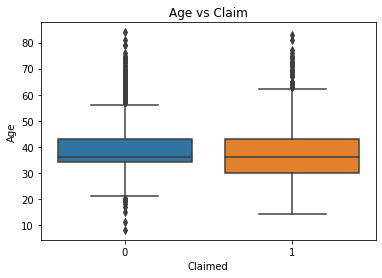

In [100]:
sns.boxplot(data=data,y='Age',x='Claimed')
plt.title('Age vs Claim')

Text(0.5, 1.0, 'Agency vs claim')

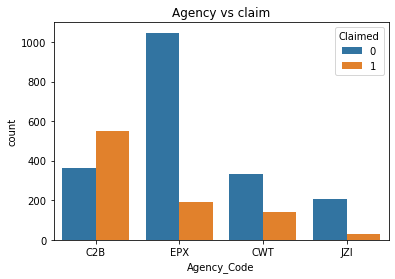

In [101]:
sns.countplot(data=data,x='Agency_Code',hue='Claimed')
plt.title('Agency vs claim')

Text(0.5, 1.0, 'Type vs claim')

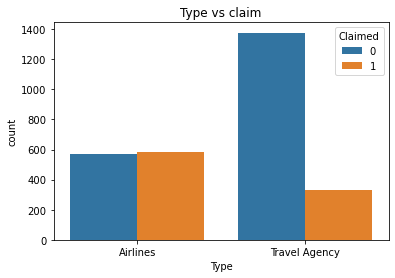

In [102]:
sns.countplot(data=data,x='Type',hue='Claimed')
plt.title('Type vs claim')

Text(0.5, 1.0, ' Commison on Type')

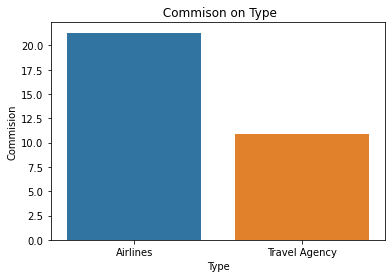

In [103]:
sns.barplot(data=data,x='Type',y='Commision',estimator=np.mean,ci=False)
plt.title(' Commison on Type')

Text(0.5, 1.0, ' Commison on Type')

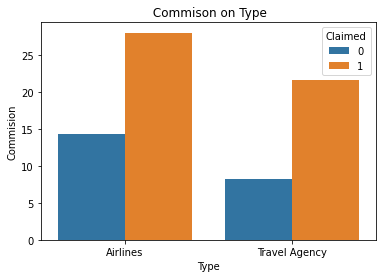

In [104]:
sns.barplot(data=data,x='Type',y='Commision',estimator=np.mean,ci=False,hue='Claimed')
plt.title(' Commison on Type')

Text(0.5, 1.0, 'Commision vs Type of Agency')

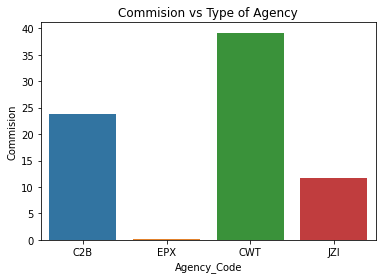

In [105]:
sns.barplot(data=data,x='Agency_Code',y='Commision',estimator=np.mean,ci=False)
plt.title('Commision vs Type of Agency')

Text(0.5, 1.0, 'Commision vs Type of Agency')

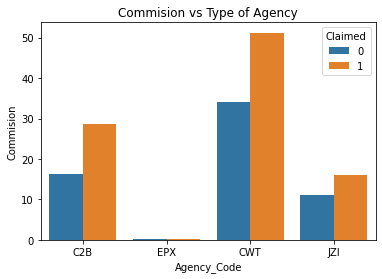

In [106]:
sns.barplot(data=data,x='Agency_Code',y='Commision',estimator=np.mean,ci=False,hue='Claimed')
plt.title('Commision vs Type of Agency')

Text(0.5, 1.0, 'Number of claims in each channel')

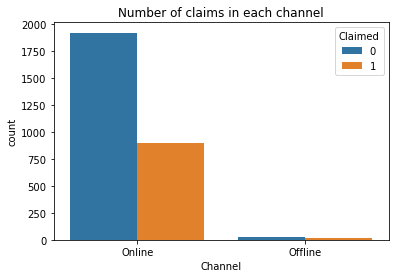

In [107]:
sns.countplot(data=data,x='Channel',hue='Claimed')
plt.title('Number of claims in each channel')

Text(0.5, 1.0, 'Sales vs claim')

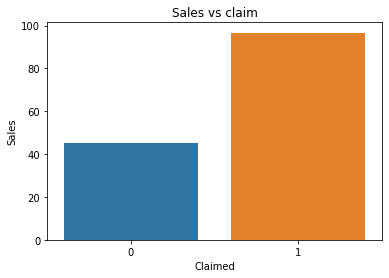

In [108]:
sns.barplot(data=data,x='Claimed',y='Sales',ci=False)
plt.title('Sales vs claim')

Text(0.5, 1.0, 'Duration vs Claimed')

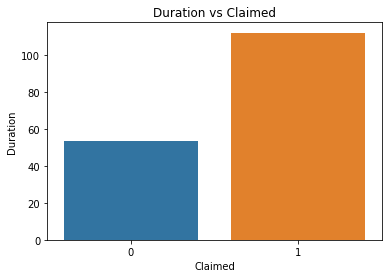

In [109]:
sns.barplot(data=data,x='Claimed',y='Duration',ci=False)
plt.title('Duration vs Claimed')

Text(0.5, 1.0, 'Plan type vs claim')

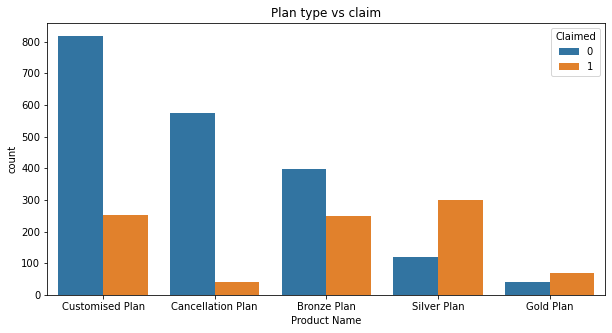

In [110]:
plt.figure(figsize=(10,5))
sns.countplot(data=data,x='Product Name',hue='Claimed')
plt.title('Plan type vs claim')

Text(0.5, 1.0, 'Destination vs claim')

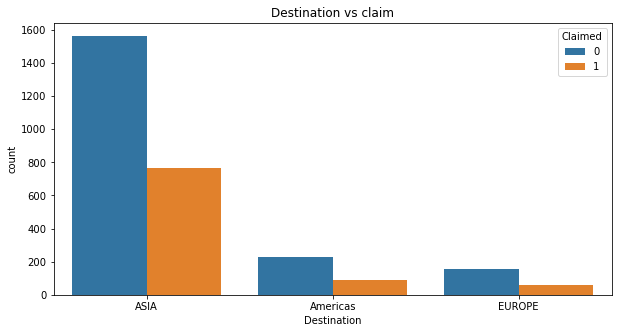

In [111]:
plt.figure(figsize=(10,5))
sns.countplot(data=data,x='Destination',hue='Claimed')
plt.title('Destination vs claim')

In [112]:
pd.crosstab(data.Claimed,[data.Destination,data.Channel])

Destination    ASIA        Americas        EUROPE
Channel     Offline Online  Offline Online Online
Claimed                                          
0                28   1535        1    230    153
1                14    750        3     85     62

Text(0.5, 1.0, 'Correlation plot')

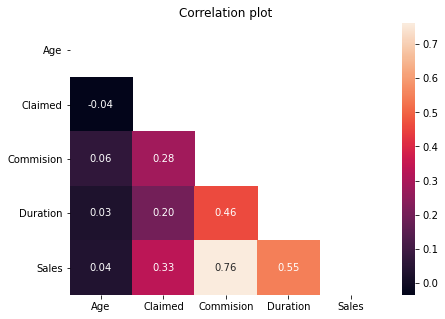

In [113]:
plt.figure(figsize=(7,5))
sns.heatmap(data.corr(),annot=True,fmt='.2f',mask=np.triu(data.corr()))
plt.title('Correlation plot')

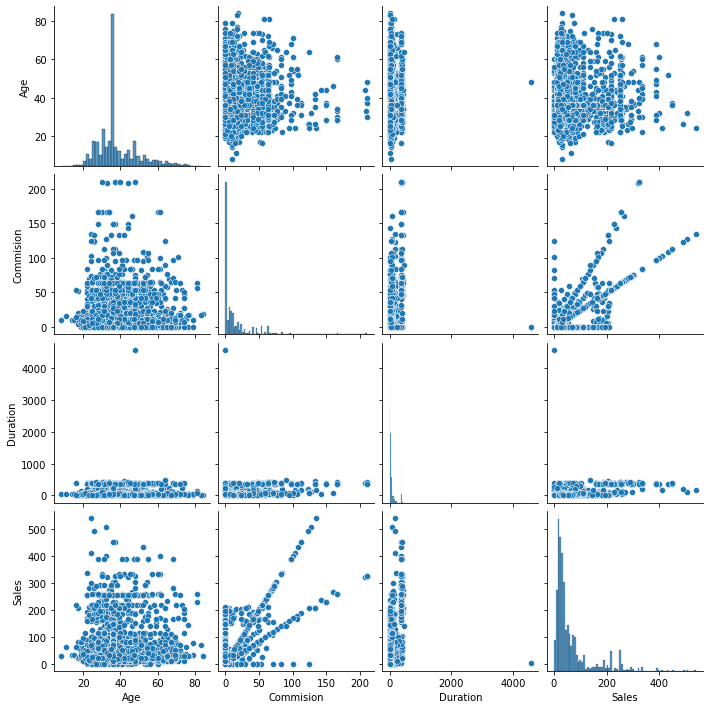

In [114]:

sns.pairplot(data=data.drop(columns='Claimed'))


Text(0.5, 1.0, 'Sales vs Commision')

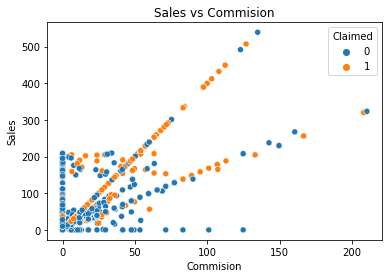

In [115]:
sns.scatterplot(data=data,x='Commision',y='Sales',hue='Claimed')
plt.title('Sales vs Commision')

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   object 
 2   Type          2861 non-null   object 
 3   Claimed       2861 non-null   int8   
 4   Commision     2861 non-null   float64
 5   Channel       2861 non-null   object 
 6   Duration      2861 non-null   int64  
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   object 
 9   Destination   2861 non-null   object 
dtypes: float64(2), int64(2), int8(1), object(5)
memory usage: 306.3+ KB


In [117]:
for column in data.columns:
    if data[column].dtype=='object':
        data[column]=pd.Categorical(data[column]).codes
        

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   int8   
 2   Type          2861 non-null   int8   
 3   Claimed       2861 non-null   int8   
 4   Commision     2861 non-null   float64
 5   Channel       2861 non-null   int8   
 6   Duration      2861 non-null   int64  
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   int8   
 9   Destination   2861 non-null   int8   
dtypes: float64(2), int64(2), int8(6)
memory usage: 208.5 KB


In [119]:
data.head()

Age  Agency_Code  Type  Claimed  Commision  Channel  Duration  Sales  \
0   48            0     0        0       0.70        1         7   2.51   
1   36            2     1        0       0.00        1        34  20.00   
2   39            1     1        0       5.94        1         3   9.90   
3   36            2     1        0       0.00        1         4  26.00   
4   33            3     0        0       6.30        1        53  18.00   

   Product Name  Destination  
0             2            0  
1             2            0  
2             2            1  
3             1            0  
4             0            0

In [120]:
X=data.drop(['Claimed'],axis=1)
y=data.pop('Claimed')

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1)

In [122]:
y_train.value_counts(normalize=True)

0    0.678821
1    0.321179
Name: Claimed, dtype: float64

In [123]:
y_test.value_counts(normalize=True)

0    0.684517
1    0.315483
Name: Claimed, dtype: float64

## Decision Tree 

In [124]:
model_tree=DecisionTreeClassifier(random_state=2,criterion='gini')

In [125]:
model_tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=2)

In [126]:
print (pd.DataFrame(model_tree.feature_importances_, columns = ["Imp"], index = X_train.columns))

                   Imp
Age           0.185671
Agency_Code   0.169511
Type          0.000000
Commision     0.083704
Channel       0.003908
Duration      0.272335
Sales         0.228412
Product Name  0.031242
Destination   0.025218


In [129]:
y_train_predict_tree=model_tree.predict(X_train)
y_predict_tree=model_tree.predict(X_test)

In [130]:
print('Train dataset')
print('Accuracy score :',accuracy_score(y_train,y_train_predict_tree))
print('Area under Curve is', roc_auc_score(y_train,model_tree.predict_proba(X_train)[:,1]))
print('Classification Report :','\n',classification_report(y_train,y_train_predict_tree))
print('Confusion matrix','\n',confusion_matrix(y_train,y_train_predict_tree))

Train dataset
Accuracy score : 0.9955044955044955
Area under Curve is 0.9999536526835096
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1359
           1       1.00      0.99      0.99       643

    accuracy                           1.00      2002
   macro avg       1.00      0.99      0.99      2002
weighted avg       1.00      1.00      1.00      2002

Confusion matrix 
 [[1359    0]
 [   9  634]]


In [131]:
print('Test dataset')
print('Accuracy score :',accuracy_score(y_test,y_predict_tree))
print('Area under Curve is', roc_auc_score(y_test,model_tree.predict_proba(X_test)[:,1]))
print('Classification Report :','\n',classification_report(y_test,y_predict_tree))
print('Confusion matrix','\n',confusion_matrix(y_test,y_predict_tree))

Test dataset
Accuracy score : 0.7031431897555297
Area under Curve is 0.6545391219218314
Classification Report : 
               precision    recall  f1-score   support

           0       0.78      0.79      0.78       588
           1       0.53      0.52      0.52       271

    accuracy                           0.70       859
   macro avg       0.66      0.65      0.65       859
weighted avg       0.70      0.70      0.70       859

Confusion matrix 
 [[464 124]
 [131 140]]


In [188]:
DecisionTreeClassifier(max_depth=7,max_features=5,min_samples_split=3,)

DecisionTreeClassifier(max_depth=7, max_features=5, min_samples_split=3)

In [189]:
param_grid={'max_depth':[5,6,7,8],
            'max_features':[3,4,5,6],
            }

model_tree=DecisionTreeClassifier(random_state=0)
grid_search=GridSearchCV(estimator=model_tree,param_grid=param_grid,cv=3)

In [190]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_features': [3, 4, 5, 6]})

In [191]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features=4, random_state=0)

In [132]:
model_tree=DecisionTreeClassifier(max_depth=6,max_features=4,random_state=0)

In [133]:
model_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, max_features=4, random_state=0)

In [265]:
y_train_predict_tree=model_tree.predict(X_train)
y_predict_tree=model_tree.predict(X_test)


Accuracy score : 0.9955044955044955
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1359
           1       1.00      0.99      0.99       643

    accuracy                           1.00      2002
   macro avg       1.00      0.99      0.99      2002
weighted avg       1.00      1.00      1.00      2002

Confusion matrix 
 [[1359    0]
 [   9  634]]
Area under Curve is 0.8460662572081522


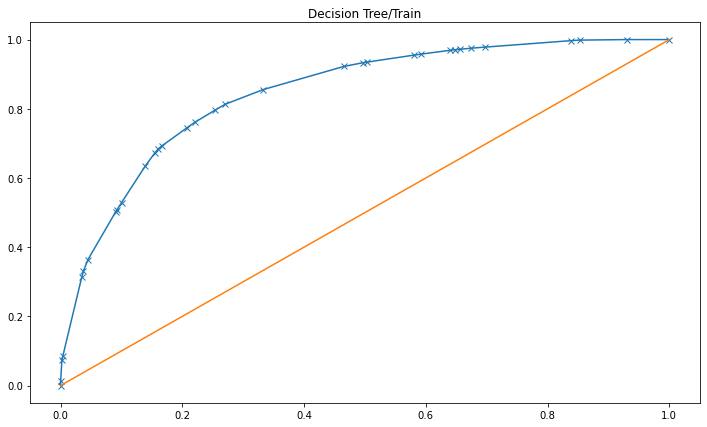

In [134]:
print('Accuracy score :',accuracy_score(y_train,y_train_predict_tree))

print('Classification Report :','\n',classification_report(y_train,y_train_predict_tree))
print('Confusion matrix','\n',confusion_matrix(y_train,y_train_predict_tree))

fpr, tpr,threshold=roc_curve(y_train,model_tree.predict_proba(X_train)[:,1])
plt.figure(figsize=(12,7))
plt.plot(fpr,tpr, marker='x', label='Decision Tree')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.title('Decision Tree/Train')
print('Area under Curve is', roc_auc_score(y_train,model_tree.predict_proba(X_train)[:,1]))

Accuracy score : 0.7031431897555297
Classification Report : 
               precision    recall  f1-score   support

           0       0.78      0.79      0.78       588
           1       0.53      0.52      0.52       271

    accuracy                           0.70       859
   macro avg       0.66      0.65      0.65       859
weighted avg       0.70      0.70      0.70       859

Confusion matrix 
 [[464 124]
 [131 140]]
Area under Curve is 0.7865489369179406


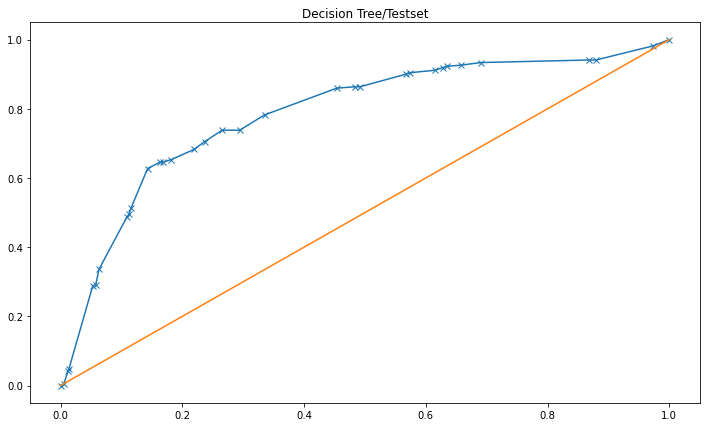

In [135]:
print('Accuracy score :',accuracy_score(y_test,y_predict_tree))

print('Classification Report :','\n',classification_report(y_test,y_predict_tree))
print('Confusion matrix','\n',confusion_matrix(y_test,y_predict_tree))

fpr, tpr,threshold=roc_curve(y_test,model_tree.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,7))
plt.plot(fpr,tpr, marker='x', label='Decision Tree')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.title('Decision Tree/Testset')
print('Area under Curve is', roc_auc_score(y_test,model_tree.predict_proba(X_test)[:,1]))

## Random Forest 

In [136]:
model_forest=RandomForestClassifier(n_estimators=500,criterion='gini',random_state=0,max_features=4,max_depth=8)

In [137]:
model_forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features=4, n_estimators=500,
                       random_state=0)

In [138]:
y_train_predict_forest=model_forest.predict(X_train)
y_predict_forest=model_forest.predict(X_test)

In [139]:
print('Train dataset')
print('Accuracy score :',accuracy_score(y_train,y_train_predict_forest))
print('Area under Curve is', roc_auc_score(y_train,model_forest.predict_proba(X_train)[:,1]))
print('Classification Report :','\n',classification_report(y_train,y_train_predict_forest))
print('Confusion matrix','\n',confusion_matrix(y_train,y_train_predict_forest))

Train dataset
Accuracy score : 0.8521478521478522
Area under Curve is 0.9194477917506354
Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1359
           1       0.82      0.69      0.75       643

    accuracy                           0.85      2002
   macro avg       0.84      0.81      0.82      2002
weighted avg       0.85      0.85      0.85      2002

Confusion matrix 
 [[1261   98]
 [ 198  445]]


In [277]:
print('Test dataset')
print('Accuracy score :',accuracy_score(y_test,y_predict_forest))
print('Area under Curve is', roc_auc_score(y_test,model_forest.predict_proba(X_test)[:,1]))
print('Classification Report :','\n',classification_report(y_test,y_predict_forest))
print('Confusion matrix','\n',confusion_matrix(y_test,y_predict_forest))

Accuracy score : 0.7823050058207218
Area under Curve is 0.8161382634234506
Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       588
           1       0.68      0.59      0.63       271

    accuracy                           0.78       859
   macro avg       0.75      0.73      0.74       859
weighted avg       0.78      0.78      0.78       859

Confusion matrix 
 [[511  77]
 [110 161]]


In [278]:
param_grid = {
    'max_depth': [8,9,10],
    'max_features': [4,5,6],
    'n_estimators': [400,500]
}

model_forest=RandomForestClassifier(random_state=0,criterion='gini')
grid_search=GridSearchCV(estimator=model_forest,param_grid=param_grid,cv=3)

In [279]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [8, 9, 10], 'max_features': [4, 5, 6],
                         'n_estimators': [400, 500]})

In [280]:
grid_search.best_params_

{'max_depth': 8, 'max_features': 4, 'n_estimators': 500}

In [140]:
model_forest=RandomForestClassifier(n_estimators=500,max_depth=8,max_features=4)

In [141]:
model_forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features=4, n_estimators=500)

In [142]:
y_train_predict_forest=model_forest.predict(X_train)
y_predict_forest=model_forest.predict(X_test)

Accuracy score : 0.8516483516483516
Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1359
           1       0.82      0.69      0.75       643

    accuracy                           0.85      2002
   macro avg       0.84      0.81      0.82      2002
weighted avg       0.85      0.85      0.85      2002

Confusion matrix 
 [[1261   98]
 [ 199  444]]
Area under Curve is 0.920155017468933


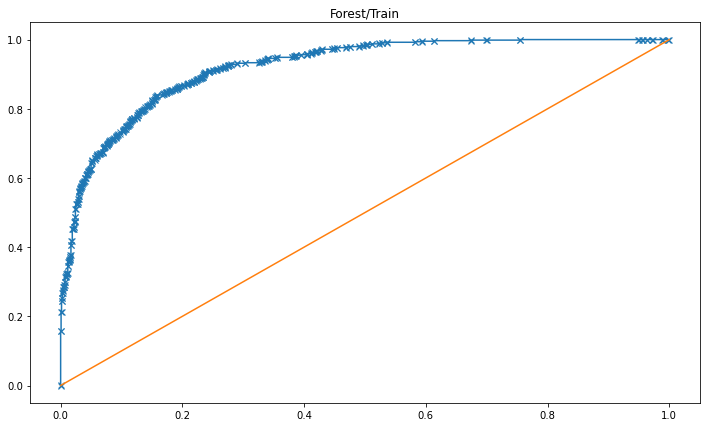

In [143]:
print('Accuracy score :',accuracy_score(y_train,y_train_predict_forest))

print('Classification Report :','\n',classification_report(y_train,y_train_predict_forest))
print('Confusion matrix','\n',confusion_matrix(y_train,y_train_predict_forest))

fpr, tpr,threshold=roc_curve(y_train,model_forest.predict_proba(X_train)[:,1])
plt.figure(figsize=(12,7))
plt.plot(fpr,tpr, marker='x', label='Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.title('Forest/Train')
print('Area under Curve is', roc_auc_score(y_train,model_forest.predict_proba(X_train)[:,1]))

Accuracy score : 0.7834691501746216
Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       588
           1       0.68      0.59      0.63       271

    accuracy                           0.78       859
   macro avg       0.75      0.73      0.74       859
weighted avg       0.78      0.78      0.78       859

Confusion matrix 
 [[512  76]
 [110 161]]
Area under Curve is 0.8161194367045711


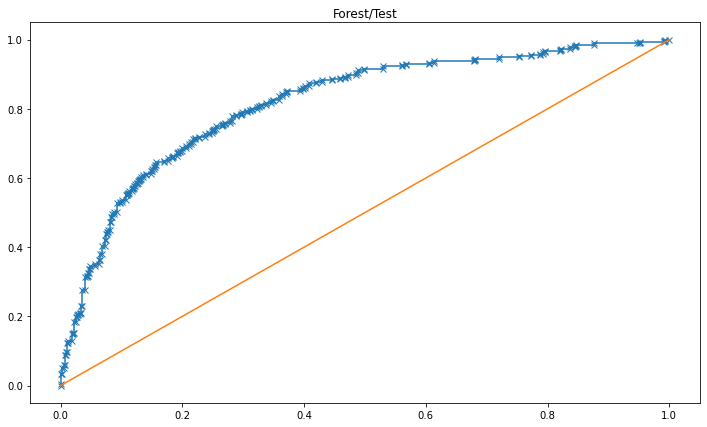

In [144]:
print('Accuracy score :',accuracy_score(y_test,y_predict_forest))

print('Classification Report :','\n',classification_report(y_test,y_predict_forest))
print('Confusion matrix','\n',confusion_matrix(y_test,y_predict_forest))

fpr, tpr,threshold=roc_curve(y_test,model_forest.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,7))
plt.plot(fpr,tpr, marker='x', label='Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.title('Forest/Test')
print('Area under Curve is', roc_auc_score(y_test,model_forest.predict_proba(X_test)[:,1]))

## Neural Network

In [147]:
sc=StandardScaler()


In [148]:
X_train[num_cols]=sc.fit_transform(X_train[num_cols])

<ipython-input-148-0166cf62d41a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_cols]=sc.fit_transform(X_train[num_cols])
E:\ProgramFiles\anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [149]:
X_test[num_cols]=sc.transform(X_test[num_cols])

<ipython-input-149-16e6c148d297>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[num_cols]=sc.transform(X_test[num_cols])
E:\ProgramFiles\anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [150]:
model_ann=MLPClassifier(hidden_layer_sizes=(500,500,500),random_state=0,solver='sgd',verbose=True,max_iter=1000,tol=0.001)

In [151]:
model_ann.fit(X_train,y_train)

Iteration 1, loss = 0.65636781
Iteration 2, loss = 0.63167025
Iteration 3, loss = 0.61018149
Iteration 4, loss = 0.59367550
Iteration 5, loss = 0.58252787
Iteration 6, loss = 0.57381639
Iteration 7, loss = 0.56586491
Iteration 8, loss = 0.55876076
Iteration 9, loss = 0.55325130
Iteration 10, loss = 0.54858260
Iteration 11, loss = 0.54448149
Iteration 12, loss = 0.54054673
Iteration 13, loss = 0.53731074
Iteration 14, loss = 0.53441536
Iteration 15, loss = 0.53132116
Iteration 16, loss = 0.52918692
Iteration 17, loss = 0.52717653
Iteration 18, loss = 0.52601031
Iteration 19, loss = 0.52520727
Iteration 20, loss = 0.52441058
Iteration 21, loss = 0.52282130
Iteration 22, loss = 0.52152608
Iteration 23, loss = 0.52113202
Iteration 24, loss = 0.52025587
Iteration 25, loss = 0.51964227
Iteration 26, loss = 0.51881302
Iteration 27, loss = 0.51787048
Iteration 28, loss = 0.51734418
Iteration 29, loss = 0.51698480
Iteration 30, loss = 0.51849962
Iteration 31, loss = 0.51840471
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(500, 500, 500), max_iter=1000, random_state=0,
              solver='sgd', tol=0.001, verbose=True)

In [155]:
y_train_predict_ann=model_ann.predict(X_train)
y_predict_ann=model_ann.predict(X_test)

In [156]:
print('Train dataset')
print('Accuracy score :',accuracy_score(y_train,y_train_predict_ann))
print('Area under Curve is', roc_auc_score(y_train,model_ann.predict_proba(X_train)[:,1]))
print('Classification Report :','\n',classification_report(y_train,y_train_predict_ann))
print('Confusion matrix','\n',confusion_matrix(y_train,y_train_predict_ann))

Train dataset
Accuracy score : 0.7482517482517482
Area under Curve is 0.7819015445672363
Classification Report : 
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1359
           1       0.68      0.41      0.51       643

    accuracy                           0.75      2002
   macro avg       0.72      0.66      0.67      2002
weighted avg       0.74      0.75      0.73      2002

Confusion matrix 
 [[1235  124]
 [ 380  263]]


In [154]:
print('Test dataset')
print('Accuracy score :',accuracy_score(y_test,y_predict_ann))
print('Area under Curve is', roc_auc_score(y_test,model_ann.predict_proba(X_test)[:,1]))
print('Classification Report :','\n',classification_report(y_test,y_predict_ann))
print('Confusion matrix','\n',confusion_matrix(y_test,y_predict_ann))

Test dataset
Accuracy score : 0.7508731082654249
Area under Curve is 0.8001167256570524
Classification Report : 
               precision    recall  f1-score   support

           0       0.76      0.92      0.84       588
           1       0.69      0.38      0.49       271

    accuracy                           0.75       859
   macro avg       0.73      0.65      0.66       859
weighted avg       0.74      0.75      0.73       859

Confusion matrix 
 [[542  46]
 [168 103]]


In [157]:
param_grid = {
    'hidden_layer_sizes': [(300,300,300),(500,500,500)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'tol': [0.1,0.01],
    'max_iter' : [10000]
}

model_ann=MLPClassifier(random_state=0)
grid_search = GridSearchCV(estimator = model_ann, param_grid = param_grid, cv = 3)

In [158]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(random_state=0),
             param_grid={'activation': ['logistic', 'relu'],
                         'hidden_layer_sizes': [(300, 300, 300),
                                                (500, 500, 500)],
                         'max_iter': [10000], 'solver': ['sgd', 'adam'],
                         'tol': [0.1, 0.01]})

In [256]:
grid_search.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (500, 500, 500),
 'max_iter': 10000,
 'solver': 'adam',
 'tol': 0.1}

In [161]:
model_ann=MLPClassifier(hidden_layer_sizes=(500,500,500),activation='relu',max_iter=1000,solver='adam',tol=0.1)
model_ann.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(500, 500, 500), max_iter=1000, tol=0.1)

In [162]:
y_train_predict_ann=model_ann.predict(X_train)
y_predict_ann=model_ann.predict(X_test)

Accuracy score : 0.7652347652347652
Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      1359
           1       0.64      0.61      0.62       643

    accuracy                           0.77      2002
   macro avg       0.73      0.72      0.73      2002
weighted avg       0.76      0.77      0.76      2002

Confusion matrix 
 [[1142  217]
 [ 253  390]]
Area under Curve is 0.8033529136440778


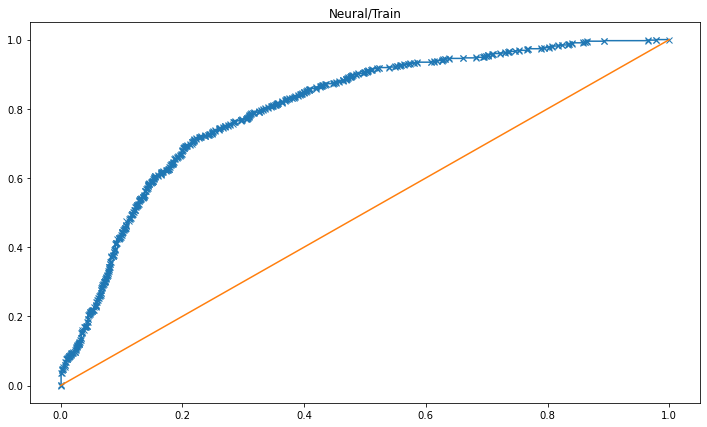

In [163]:
print('Accuracy score :',accuracy_score(y_train,y_train_predict_ann))

print('Classification Report :','\n',classification_report(y_train,y_train_predict_ann))
print('Confusion matrix','\n',confusion_matrix(y_train,y_train_predict_ann))

fpr, tpr,threshold=roc_curve(y_train,model_ann.predict_proba(X_train)[:,1])
plt.figure(figsize=(12,7))
plt.plot(fpr,tpr, marker='x', label='Neural')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.title('Neural/Train')
print('Area under Curve is', roc_auc_score(y_train,model_ann.predict_proba(X_train)[:,1]))

Accuracy score : 0.7671711292200233
Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       588
           1       0.64      0.61      0.62       271

    accuracy                           0.77       859
   macro avg       0.73      0.72      0.73       859
weighted avg       0.76      0.77      0.77       859

Confusion matrix 
 [[494  94]
 [106 165]]
Area under Curve is 0.8158244847754601


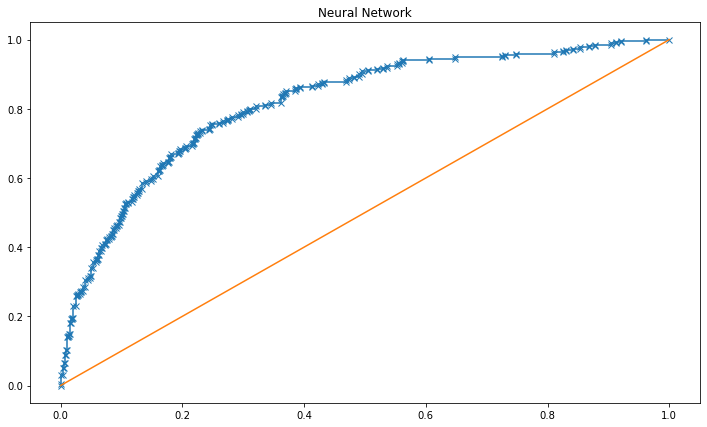

In [271]:
print('Accuracy score :',accuracy_score(y_test,y_predict_ann))

print('Classification Report :','\n',classification_report(y_test,y_predict_ann))
print('Confusion matrix','\n',confusion_matrix(y_test,y_predict_ann))

fpr, tpr,threshold=roc_curve(y_test,model_ann.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,7))
plt.plot(fpr,tpr, marker='x', label='Neural Network')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.title('Neural Network/Test')
print('Area under Curve is', roc_auc_score(y_test,model_ann.predict_proba(X_test)[:,1]))

No handles with labels found to put in legend.


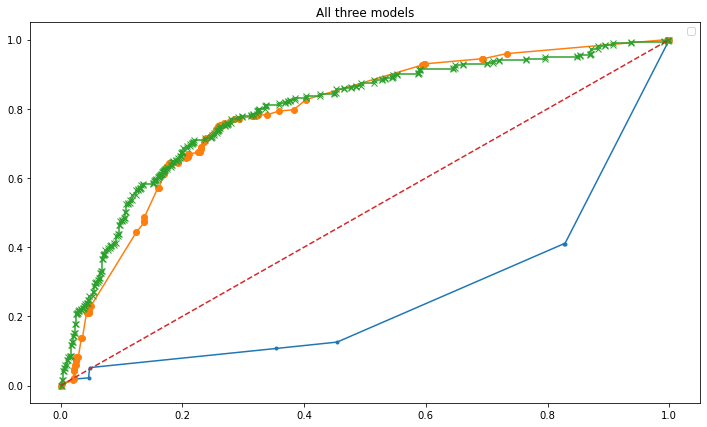

In [192]:
plt.figure(figsize=(12,7))
fpr, tpr, thresholds = roc_curve(y_test, model_tree.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, marker='.') 

fpr, tpr, thresholds = roc_curve(y_test, model_forest.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, marker='o') 

fpr, tpr, thresholds = roc_curve(y_test,model_ann.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, marker='x') 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('All three models')

Age doesnt affect the claim
Most of the claim is done byC2B agency and least by JZI
Most of the claim is by airways travel
We have the most of the claim from the high commision travels by airlines
Most of the claims are in silver plan and gold plan
Most of the claims are from asia destination

In [176]:
a=classification_report(y_test,y_predict_ann,output_dict=True)

In [191]:
index=['accuracy','AUC','f1']
pd.DataFrame({'Decision_tree':[0.70,0.79,0.52],
              'Random_Forest':[0.78,0.82,0.63],
              'Neural_net':[0.78,0.82,0.62],
    
},index=index)

Decision_tree  Random_Forest  Neural_net
accuracy           0.70           0.78        0.78
AUC                0.79           0.82        0.82
f1                 0.52           0.63        0.62

In [188]:
classification_report(y_test,y_predict_ann,output_dict=True)['1']['f1-score']

0.6171428571428571